In [10]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-07-18 18:03:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-18 18:03:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-18 18:03:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [81]:
import pandas as pd

df = pd.DataFrame()
df = pd.read_csv('new_books_summary.csv')
df

,Unnamed: 0,book_name,cleaned_text,cleaned_text_length,cleaned_genre
0,8,Blade Runner 3: Replicant Night,"['living', 'mar', 'deckard', 'acting', 'consul...",27,"['Science Fiction', 'Speculative fiction']"
1,9,Blade Runner 2: The Edge of Human,"['beginning', 'several', 'month', 'event', 'bl...",163,"['Science Fiction', 'Speculative fiction']"
2,20,Crash,"['story', 'told', 'eye', 'narrator', 'james', ...",55,"['Novel', 'Speculative fiction', 'Fiction']"
3,25,The Cider House Rules,"['homer', 'well', 'grows', 'orphanage', 'spend...",293,['Fiction']
4,31,Death of a Hero,"['death', 'hero', 'story', 'young', 'english',...",194,['Fiction']
...,...,...,...,...,...
7672,16544,Heaven,"['heaven', 'leigh', 'casteel', 'fourteen', 'ye...",655,['Fiction']
7673,16549,The Third Lynx,"['story', 'start', 'former', 'government', 'ag...",85,['Science Fiction']
7674,16551,Remote Control,"['series', 'follows', 'character', 'nick', 'st...",34,['Fiction']
7675,16555,Transfer of Power,"['reader', 'first', 'meet', 'rapp', 'covert', ...",114,['Fiction']


In [82]:
def loop_list(original_list):
    new_list = []
#     print(original_list)
    for item in original_list:
        new_list.append(item.strip())
    return new_list
df['cleaned_text'] = df['cleaned_text'].apply(lambda x:x.replace("[",'').replace(']','').replace("\"",'').replace('\'','').split(','))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x:"".join(x))
df['cleaned_genre'] = df['cleaned_genre'].apply(lambda x:x.replace("[",'').replace(']','').replace("\"",'').replace('\'','').split(','))
df['cleaned_genre'] = df['cleaned_genre'].apply(lambda x:loop_list(x))
labels_list = []
df['cleaned_genre'].apply(lambda x:labels_list.extend(x))

0       None
1       None
2       None
3       None
4       None
        ... 
7672    None
7673    None
7674    None
7675    None
7676    None
Name: cleaned_genre, Length: 7677, dtype: object

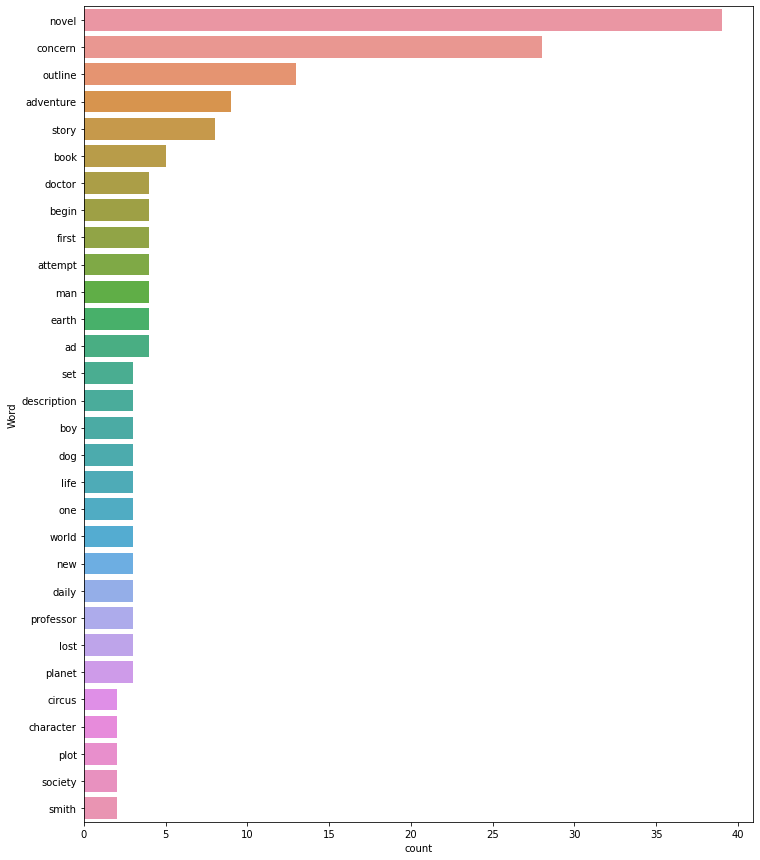

In [21]:
# import nltk
# import seaborn as sns
# def freq_words(x, terms = 30): 
#     all_words = ' '.join([text for text in x]) 
#     all_words = all_words.split() 
#     fdist = nltk.FreqDist(all_words) 
#     words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

#     # selecting top 20 most frequent words 
#     d = words_df.nlargest(columns="count", n = terms) 

#     # visualize words and frequencies
#     plt.figure(figsize=(12,15)) 
#     ax = sns.barplot(data=d, x= "count", y = "word") 
#     ax.set(ylabel = 'Word') 
#     plt.show()
# freq_words(df['cleaned_text'][df['cleaned_text_length'].apply(lambda x:x<10)],30)
# new_stop_words = ['outline','description','book','plot']
# def loop_common_type(origin_list,target_list):
#     removed_list = []
#     for item in origin_list:
#         if item in target_list:
#             removed_list.append(item)
#     cleaned_list = list(set(origin_list)-set(removed_list))
#     return cleaned_list

# df['cleaned_text'] = df['cleaned_text'].apply(lambda x:loop_common_type(x,new_stop_words))

In [83]:
df['cleaned_text']

0       living mar deckard acting consultant movie cre...
1       beginning several month event blade runner dec...
2       story told eye narrator james ballard named au...
3       homer well grows orphanage spends childhood us...
4       death hero story young english artist named ge...
                              ...                        
7672    heaven leigh casteel fourteen year old girl li...
7673    story start former government agent frank comp...
7674    series follows character nick stone man previo...
7675    reader first meet rapp covert operation iran d...
7676    makar devushkin varvara dobroselova second cou...
Name: cleaned_text, Length: 7677, dtype: object

In [84]:
labels_list = set(labels_list)
labels_list

{'Childrens literature',
 'Fantasy',
 'Fiction',
 'Novel',
 'Science Fiction',
 'Speculative fiction'}

In [85]:
x = []
sentences = list(df["cleaned_text"])
for sen in sentences:
    x.append(sen)

#One hot encoding. I just found an easy way to do that. Do not need that another process
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['cleaned_genre'])

# transform target variable
y = multilabel_binarizer.transform(df['cleaned_genre'])

In [86]:
print(x[2])
print(y[2])

story told eye narrator james ballard named author center sinister figure robert vaughan former turned nightmare angel expressway ballard meet vaughan involved car accident near london airport gathering around vaughan group alienated people former follow pursuit crash celebrity experience narrator call new sexuality born perverse technology vaughan ultimate fantasy die collision movie star elizabeth taylor
[0 0 1 1 0 1]


In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [88]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [89]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
# LSTM_Layer_2 = LSTM(128)(LSTM_Layer_1)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [90]:
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 50)            3295300   
                                                                 
 lstm_3 (LSTM)               (None, 128)               91648     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 3,387,722
Trainable params: 92,422
Non-trainable params: 3,295,300
_________________________________________________________________
None


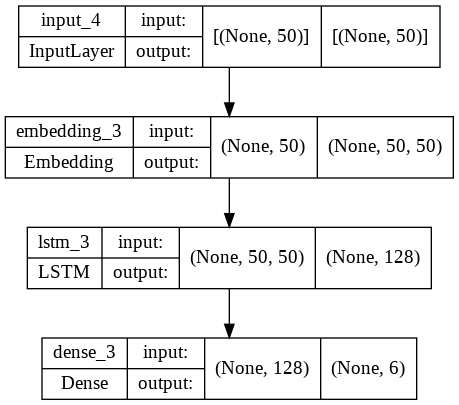

In [91]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

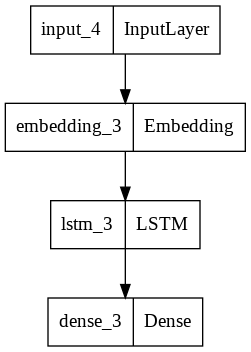

In [92]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [93]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
history = model.fit(X_train, y_train, batch_size=64, epochs=20,validation_data=(X_test,y_test),callbacks=earlystop)

Epoch 1/20
108/108 [==============================] - 13s 100ms/step - loss: 0.5321 - acc: 0.2109 - val_loss: 0.4945 - val_acc: 0.2760
Epoch 2/20
108/108 [==============================] - 10s 95ms/step - loss: 0.4832 - acc: 0.3471 - val_loss: 0.4812 - val_acc: 0.3776
Epoch 3/20
108/108 [==============================] - 10s 94ms/step - loss: 0.4590 - acc: 0.3976 - val_loss: 0.4615 - val_acc: 0.4167
Epoch 4/20
108/108 [==============================] - 10s 94ms/step - loss: 0.4509 - acc: 0.4137 - val_loss: 0.4530 - val_acc: 0.4271
Epoch 5/20
108/108 [==============================] - 10s 94ms/step - loss: 0.4405 - acc: 0.4276 - val_loss: 0.4469 - val_acc: 0.4297
Epoch 6/20
108/108 [==============================] - 10s 95ms/step - loss: 0.4363 - acc: 0.4289 - val_loss: 0.4481 - val_acc: 0.4271
Epoch 7/20
108/108 [==============================] - 10s 95ms/step - loss: 0.4293 - acc: 0.4345 - val_loss: 0.4476 - val_acc: 0.4401
Epoch 8/20
108/108 [==============================] - 10s 94m

In [94]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

24/24 [==============================] - 1s 20ms/step - loss: 0.4757 - acc: 0.4180
Test Score: 0.47573015093803406
Test Accuracy: 0.41796875


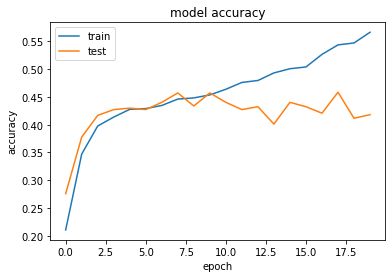

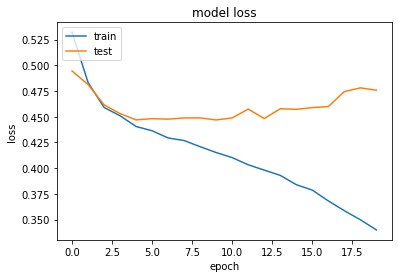

In [95]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [97]:
from sklearn.metrics import precision_score,recall_score,f1_score

predictions=model.predict(X_test)
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
    print("Threshold: {:.1f}".format(val))
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Threshold: 0.1
Micro-average quality numbers
Precision: 0.4029, Recall: 0.8797, F1-measure: 0.5527
Threshold: 0.2
Micro-average quality numbers
Precision: 0.4678, Recall: 0.7826, F1-measure: 0.5855
Threshold: 0.3
Micro-average quality numbers
Precision: 0.5237, Recall: 0.7054, F1-measure: 0.6011
Threshold: 0.4
Micro-average quality numbers
Precision: 0.5576, Recall: 0.6025, F1-measure: 0.5792
Threshold: 0.5
Micro-average quality numbers
Precision: 0.5881, Recall: 0.5012, F1-measure: 0.5412
Threshold: 0.6
Micro-average quality numbers
Precision: 0.6331, Recall: 0.4066, F1-measure: 0.4952
Threshold: 0.7
Micro-average quality numbers
Precision: 0.6694, Recall: 0.2739, F1-measure: 0.3887
Threshold: 0.8
Micro-average quality numbers
Precision: 0.7383, Recall: 0.1826, F1-measure: 0.2927
Threshold: 0.9
Micro-average quality numbers
Precision: 0.8082, Recall: 0.0979, F1-measure: 0.1747


In [37]:
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint(filepath='best_model.h5',moniter='val_acc',mode='max',verbose=1,save_best_only=True)

In [108]:
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = y_pred >0.3
conf_mat = multilabel_confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred,target_names=labels_list))
# print(conf_mat)
# fig, ax = plt.subplots(figsize=(10,8))
# sns.heatmap(conf_mat, annot=True,fmt='d',xticklabels=labels_list,yticklabels=labels_list)
# plt.ylabel('Real Result',fontsize=18)
# plt.xlabel('Prodiction Result',fontsize=18)

                      precision    recall  f1-score   support

             Fantasy       0.51      0.52      0.52       134
     Science Fiction       0.59      0.71      0.64       156
 Speculative fiction       0.50      0.75      0.60       274
             Fiction       0.47      0.67      0.55       204
               Novel       0.65      0.70      0.67       172
Childrens literature       0.50      0.78      0.61       265

           micro avg       0.52      0.71      0.60      1205
           macro avg       0.54      0.69      0.60      1205
        weighted avg       0.53      0.71      0.60      1205
         samples avg       0.53      0.72      0.58      1205

